In [2]:
%pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=09ea830aad4e3a81119a635231883c3a18e9451544a9eb8ce08943a155ca405c
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


### 1. Imports

In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### 2. Chargement & préparation des données

In [8]:
df = pd.read_csv('./^GSPC_5m_1mo.csv')
df.head()

,PC1,PC2,PC3,PC4,Close
0,-1.403333,0.856831,-2.680629,-1.321891,5943.149902
1,-1.325378,0.663047,-2.689698,-1.323257,5945.439941
2,-0.864499,0.505574,0.226711,-1.916577,5952.040039
3,-0.983145,0.725221,0.048840,-1.862095,5946.120117
4,-0.923006,0.485386,-0.114305,-1.844814,5949.490234


In [9]:
# Séparer en features et target
df_features = df.drop('Close', axis=1)
target = df['Close']

In [24]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

In [25]:
df_features_scaled = scaler_features.fit_transform(df_features)
target_scaled = scaler_target.fit_transform(target)

In [27]:
# Fonction pour créer les ensembles de données
def create_dataset(features, target, sequence_length=24):
    X_data, y_data = [], []
    for i in range(len(features) - sequence_length):
        X_data.append(features[i:i + sequence_length])
        y_data.append(target[i + sequence_length])  # Prendre la valeur future
    return np.array(X_data), np.array(y_data)

In [28]:
# Création des datasets
sequence_length = 24  # Fenêtre temporelle
X, y = create_dataset(df_features_scaled, target_scaled, sequence_length)

In [29]:
# Séparer en train/test (80% - 20%)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [30]:
# Vérifier les dimensions
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1084, 24, 4), y_train.shape: (1084, 1)
X_test.shape: (272, 24, 4), y_test.shape: (272, 1)


In [15]:
def create_sequences(data_features, data_target, sequence_length):
    X, y = [], []
    for i in range(len(data_features) - sequence_length):
        X.append(data_features[i:i+sequence_length])
        y.append(data_target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Longueur des séquences temporelles hyperparamètre

# Entraînement
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)

# Test
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)


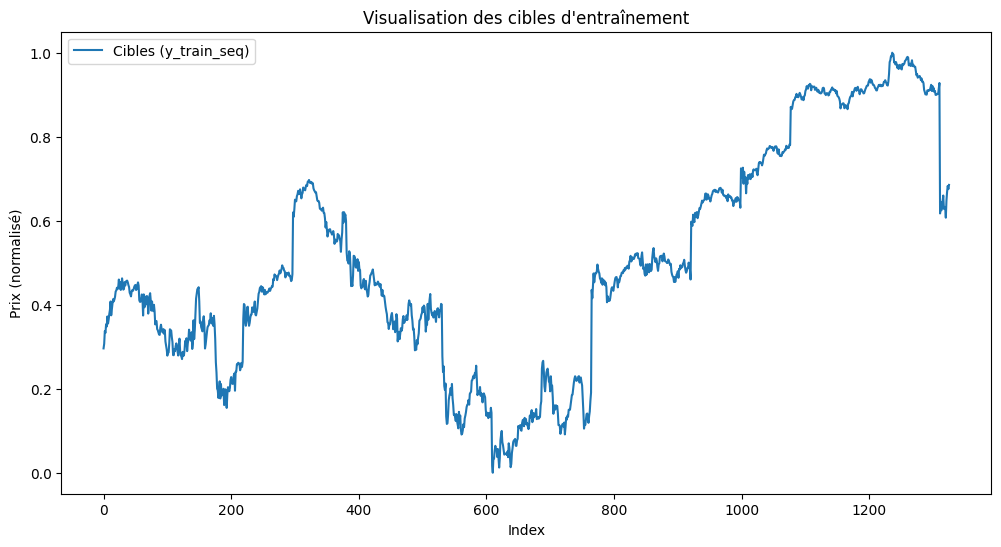

In [17]:
import matplotlib.pyplot as plt

# Reshape y_train_seq to 2D by taking the last element of the last dimension
y_train_seq_2d = y_train_seq[:, -1, 0]  # Select the last element from the last dimension

plt.figure(figsize=(12, 6))
# Plot the reshaped data
plt.plot(range(len(y_train_seq_2d)), y_train_seq_2d, label='Cibles (y_train_seq)')
plt.title("Visualisation des cibles d'entraînement")
plt.xlabel("Index")
plt.ylabel("Prix (normalisé)")
plt.legend()
plt.show()

### 3. Entrainement du modèle

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construire un modèle LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Sortie unique pour la prédiction du prix
])

# Compiler le modèle
model.compile(optimizer='adam', loss='mse')

# Résumé du modèle
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 24, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0393 - val_loss: 0.0033
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0044 - val_loss: 0.0063
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

### 4. Résultats

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


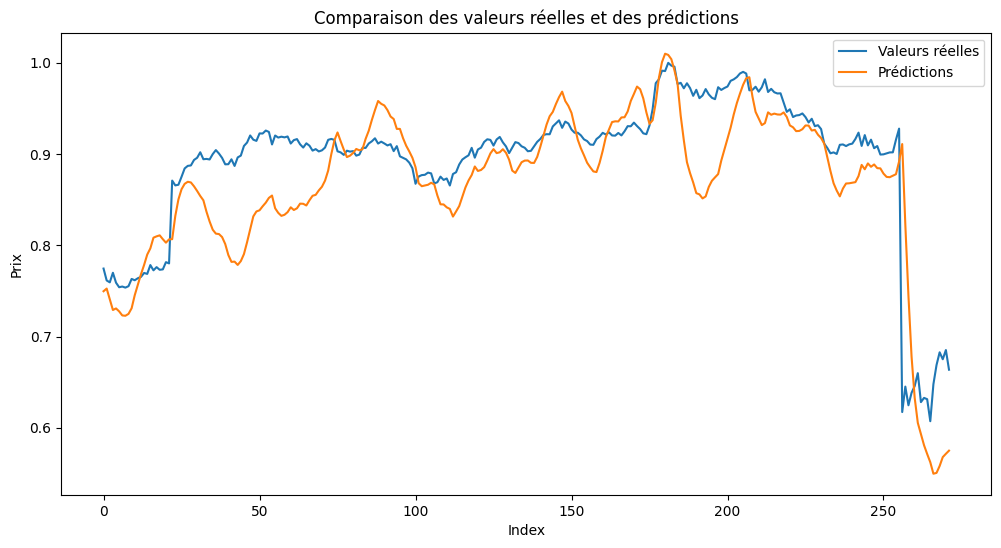

In [35]:
# Prédire sur les données de test
X_test_seq, y_test_seq = create_dataset(df_features_scaled[split_idx:], target_scaled[split_idx:], sequence_length=24)

y_pred = model.predict(X_test_seq)

# Comparer les prédictions avec les cibles
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Valeurs réelles')
plt.plot(y_pred, label='Prédictions')
plt.title("Comparaison des valeurs réelles et des prédictions")
plt.xlabel("Index")
plt.ylabel("Prix")
plt.legend()
plt.show()

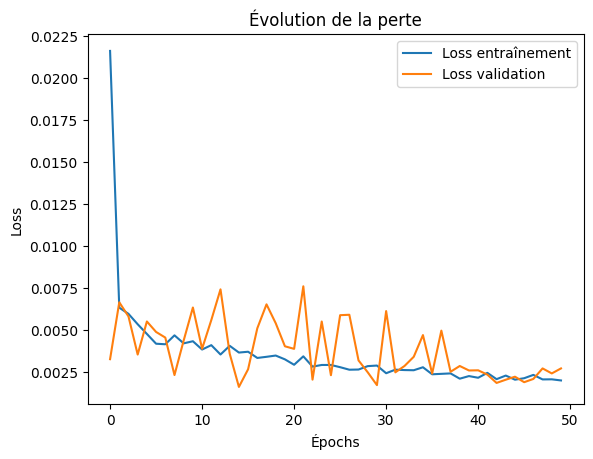

In [36]:
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title('Évolution de la perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mape = mean_absolute_percentage_error(y_test_seq, y_pred)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 0.05214945843539143
MAPE: 0.04464711537413137


*0.05* signifie que l'erreur moyenne du modèle est de 5 % par rapport aux valeurs réelles.

In [38]:
model.save('lstm.h5')